In [1]:
import sympy as sp
import time
from cnspy import cns
from cnspy import method
from cnspy import adaptive, adaptive_parameters
import mpmath
mpmath.mp.dps =500
t = sp.symbols(r't')
#number of particles
n = 3
#number of variables = number of particles * number of directions * number of position and velocity
N = n*3*2
G = sp.symbols(r'G')
rho = sp.symarray(r'\rho', n)
#position and velocity
# u_{k,i} where k is the number of directions and i is the number of particles
# the global index of velocity in u_{k,i} is 6*i+k*2
# the global index of position in u_{k,i} is 6*i+k*2+1
u=sp.symarray('x', N)
fun = []
for i in range(0,n):
    for k in range(0,3):
        force = 0
        for j in range(0,n):
            if j!=i:
                Rij = 0
                for kk in range(0,3):
                    Rij += ( u[j*6+kk*2+1] - u[i*6+kk*2+1] )**2
                force += rho[j]*(u[j*6+k*2+1]-u[i*6+k*2+1])/sp.sqrt(Rij)**3
        fun.append(force)
        fun.append(u[i*6+k*2])

vp1 = [[u[0],"0"],[u[1],"1e-60"],[u[2],"-1"],[u[3],"0"],[u[4],"0"],[u[5],"-1"]]
vp2 = [[u[6],"1"],[u[7],"0"],[u[8],"1"],[u[9],"0"],[u[10],"0"],[u[11],"0"]]
vp3 = [[u[12],"-1"],[u[13],"-1e-60"],[u[14],"0"],[u[15],"0"],[u[16],"0"],[u[17],"1"]]


initial = vp1+vp2+vp3

In [2]:
from cnspy import cluster
HN = cluster.ssh()
HN.connect()
HN.execute('sinfo')

Connected to the 192.168.1.247 server
Executing command: sinfo
Command output:
PARTITION AVAIL  TIMELIMIT  NODES  STATE NODELIST
normal*      up   infinite     11    mix cu[1-4,6,9,11-14,18]
normal*      up   infinite      7   idle cu[5,7-8,10,15-17]
fat          up   infinite      2   idle cu[19-20]

Command error (if any):



In [4]:
threebody=cns(funcs=fun,name="threebody",\
           method=method('TS'),\
           inits=initial,\
           paras=[[rho[0],"1"],[rho[1],"1"],[rho[2],"1"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           adaptive=adaptive('t','order','wordsize',delta_T=5,remaining_T=500,gamma=1.4),\
           mpi=True,\
           lyap=0.1681,\
           printprecision= 200,\
           run_os= 'posix',\
           numofprocessor=64)

Predefine wordsize is 339.
Predefine order is 177.


In [5]:
threebody.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=threebody.numofprocessor, jobname = threebody.name)
HN = cluster.ssh()
threebody.run(HN,SL)

In [10]:
#read result
threebody.read_cnssol()
#rk4 result
threebody.quick_run()

In [6]:
threebody_higher=cns(funcs=fun,name="threebody_higher",\
           method=method('TS',order=220,nosd=150),\
           inits=initial,\
           paras=[[rho[0],"1"],[rho[1],"1"],[rho[2],"1"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           adaptive=adaptive('t'),\
           mpi=True,\
           lyap=0.1681,\
           printprecision= 200,\
           run_os= 'posix',\
           numofprocessor=64)

Predefine wordsize is 499.
Predefine order is 220.


In [7]:
threebody_higher.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu5', qos='super', np=threebody_higher.numofprocessor, jobname = threebody_higher.name)
HN = cluster.ssh()
threebody_higher.run(HN,SL)

In [11]:
#read result
threebody_higher.read_cnssol()
#rk4 result
threebody_higher.quick_run()

In [8]:
threebody_fix=cns(funcs=fun,name="threebody_fix",\
           method=method('TS',order=135,nosd=90),\
           inits=initial,\
           paras=[[rho[0],"1"],[rho[1],"1"],[rho[2],"1"]],\
           tspan=(0,1000),\
           saveat=0.1,\
           adaptive=adaptive('t'),\
           mpi=True,\
           lyap=0.1681,\
           printprecision= 200,\
           run_os= 'posix',\
           numofprocessor=64)

Predefine wordsize is 299.
Predefine order is 135.


In [9]:
threebody_fix.generate_c_code()

In [ ]:
from cnspy import cluster
SL = cluster.slurm_script(node='cu10', qos='super', np=threebody_fix.numofprocessor, jobname = threebody_fix.name)
HN = cluster.ssh()
threebody_fix.run(HN,SL)

In [12]:
#read result
threebody_fix.read_cnssol()
#rk4 result
threebody_fix.quick_run()

In [13]:
import sympy as sp
def relative_error(y1, y2):
    for j in range(len(y1[:,0])):
        if j == 0:
            era = [sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
        else:
            era = [ era[i] + sp.Float(abs(y1[j,i] - y2[j,i])) for i in range(len(y1[0,:]))]
            erb = [ erb[i] + sp.Float(abs(y2[j,i])) for i in range(len(y1[0,:]))]
    return [era[i] / erb[i] for i in range(len(era))]

In [42]:
y1 = relative_error(threebody.cnssol.y, threebody_higher.cnssol.y)[::10]
y1

[0,
 5.64869420045766521748974112931157176256705868340975905745652663268864755868471669812000594e-105,
 5.03216523509234851019950222181367208643127474650973193755419800498938398651623166714229953e-105,
 3.73579028788783862757211690846985238323389105386868611215346806647673398729555136988903452e-105,
 5.98453446070755529001593294995266650265260981897913102526301700391814846969127289870385263e-105,
 8.36145039504712962275786641772609910514866123648207107689306717105055876236678826425639468e-105,
 1.26073842574047755537196067713877677343869557537403637244595878681207448610098860342460616e-104,
 1.70517773829251504988632958612671430758816835731198834754387673693796018439072545198270069e-104,
 1.78559782255628064013391347173891602932898915053510217405047744524426038617430984060342925e-104,
 3.38136210147877284562934647464309707933093207911502156952153657855732545240477338977006788e-104,
 1.47992408295897919152354636519601750331229088598533946364798753549788604159605039020141909e-103,
 4.811

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


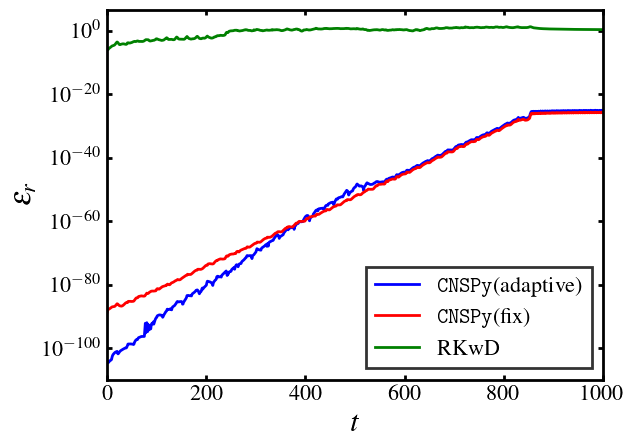

In [44]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = threebody.cnssol.t[1::10]
y1 = relative_error(threebody.cnssol.y, threebody_higher.cnssol.y)[1::10]
y2 = relative_error(threebody_fix.cnssol.y, threebody_higher.cnssol.y)[1::10]
y3 = relative_error(threebody.qrsol.y, threebody_higher.cnssol.y)[1::10]
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax = plt.subplots()

y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda x:sp.log(x, 10), y2))
y33 = list(map(lambda x:sp.log(x, 10), y3))
ax.plot(x, y11,label=r'\texttt{CNSPy}(adaptive)',linestyle="-",linewidth=2,color="blue")
ax.plot(x, y22,label=r'\texttt{CNSPy}(fix)',linestyle="-",linewidth=2,color="red")
ax.plot(x, y33,label=r'RKwD',linestyle="-",linewidth=2,color="green")
ax.yaxis.set_major_formatter(formatter)
ax.set_xlim(0,1000)
ax.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{\epsilon_r}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("threebody_error.eps",bbox_inches='tight')


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


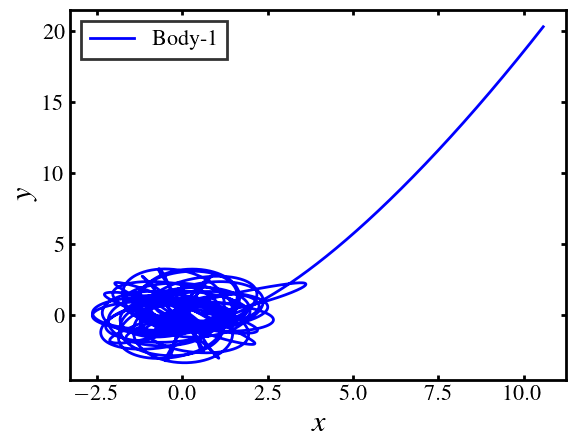

In [46]:
#plot phase space
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
fig, ax = plt.subplots()
ax.plot(threebody.cnssol.y[1,:],threebody.cnssol.y[5,:],label=r'Body-1',linestyle="-",linewidth=2,color="blue")
ax.set_xlabel(r'$\boldsymbol{x}$', fontsize=22, fontweight='bold')
ax.set_ylabel(r'$\boldsymbol{z}$', fontsize=22, fontweight='bold')
ax.tick_params(direction="in",top=True,right=True,width=2)
ax.legend(edgecolor="inherit",loc="best")
for location in  ["left", "right", "top", "bottom"]:
    ax.spines[location].set_linewidth(2)

fig.savefig("threebody_traj_cns_b1.eps")

In [20]:
import numpy as np
import mpmath
def order_nosd_time(system):
    magic_number = system.adptv_para.magic_number
    gamma = system.adptv_para.gamma
    remaining_T = system.adptv_para.remaining_T
    lyap = system.lyap 
    tmax = system.tspan[1]
    time = [i for i in range(0, tmax+1)]
    delta_T = system.adptv_para.delta_T
    order = np.zeros(len(time))
    nosd = np.zeros(len(time))
    desire_error = []
    desire_time = []
    for i in range(0, len(time)):
        if i % delta_T == 0 and i <= tmax - remaining_T:
            nosd[i] = int(gamma*lyap*(tmax-i)/np.log(10.0))
            desire_error.append(10**(-mpmath.mp.mpf(nosd[i])))
            desire_time.append(i)
        else:
            nosd[i] = nosd[i-1]
        order[i] = int(magic_number[0]*nosd[i]*nosd[i]+magic_number[1]*nosd[i]+magic_number[2])
        order[-1] = order[-2]
        nosd[-1] = nosd[-2]
        
    return time, np.array(desire_time), order, nosd, np.array(desire_error)
    

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
Failed to find a Ghostscript installation.  Distillation step skipped.


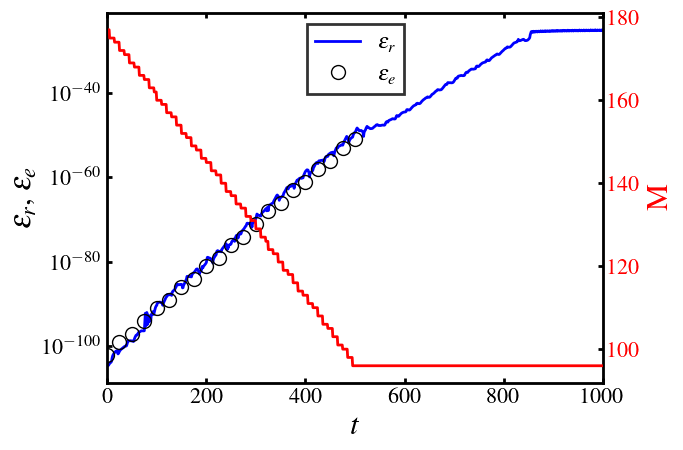

In [27]:
import matplotlib.pyplot as plt
from matplotlib import rc
rc("legend",fancybox=False)
rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{amsmath} \boldmath')
rc('patch',linewidth=2)
font = {'family' : 'serif',
        'serif':['Times'],
        'weight' : 'bold',
        'size'   : 16}
rc('font', **font)
from matplotlib.ticker import FuncFormatter

x = threebody.cnssol.t[1::10]
y1 = relative_error(threebody.cnssol.y, threebody_higher.cnssol.y)[1::10]
t_threebody, desire_time_threebody, order_threebody, nosd_threebody, desire_error_threebody = order_nosd_time(threebody)
def log_formatter(x, pos):
    return "$10^{{{:d}}}$".format(int(x))

formatter = FuncFormatter(log_formatter)

fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
y11 = list(map(lambda x:sp.log(x, 10), y1))
y22 = list(map(lambda desire_time_threebody:sp.log(desire_time_threebody, 10), desire_error_threebody))
ax1.plot(x, y11,label=r'$\boldsymbol{\epsilon_{r}}$',linestyle="-",linewidth=2,color='blue')
ax1.plot(desire_time_threebody[::5], y22[::5],label=r'$\boldsymbol{\epsilon_{e}}$',marker="o", markersize=10,color='none', markerfacecolor='none', markeredgecolor="black")
ax2.plot(x, order_threebody[:-1],label='order',linestyle="-",linewidth=2,color='red')
ax2.tick_params(direction="in",axis='y', labelcolor='red',width=2)
ax2.set_ylabel(r'M', fontsize=22, color='red', fontweight='bold')
ax1.yaxis.set_major_formatter(formatter)
ax1.set_xlim(0,1000)
ax1.set_xlabel(r'$\boldsymbol{t}$', fontsize=22, fontweight='bold')
ax1.set_ylabel(r'$\boldsymbol{\epsilon_r}$, $\boldsymbol{\epsilon_e}$', fontsize=22, fontweight='bold')
ax1.tick_params(direction="in",top=True,width=2)
ax1.legend(edgecolor="inherit",loc="upper center")
for location in  ["left", "right", "top", "bottom"]:
    ax1.spines[location].set_linewidth(2)

fig.savefig("algorithm_threebody.eps",bbox_inches='tight')